# Overview

This project is based on the dataset available at https://www.kaggle.com/c/tweet-sentiment-extraction/overview which is composed of about 20k tweets to train sentiment predictors.

This notebook will guide you through the process of tweets cleaning (a very basic NLP task when dealing with text data), training a few Deep Learning models with different architectures and finally inferencing on test text.

# Imports

In [103]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

Done


# Data importing

In [104]:
train = pd.read_csv('/content/news.csv', sep=',')

# Data exploration

In [105]:
train.head(15)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


In [106]:
#Let's get the dataset lenght
len(train)

6335

In [107]:
#Is there any other different value than neutral, negative and positive?
train['label'].unique()

array(['FAKE', 'REAL'], dtype=object)

In [108]:
#How's distributed the dataset? Is it biased?
train.groupby('label').nunique()

,Unnamed: 0,title,text
label,,,
FAKE,3164,3107,3071
REAL,3171,3149,2989


# Data cleaning

Even when the dataset is a little bit biased, we'll keep it this way because the differences are not significant.

In [109]:
#Let's keep only the columns that we're going to use
train = train[['text','label']]
train.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [110]:
#Is there any null value?
train["text"].isnull().sum()

0

In [111]:
#Let's fill the only null value.
train["text"].fillna("No content", inplace = True)

### The next steps about data cleaning will be:

* Remove URLs from the tweets
* Tokenize text
* Remove emails
* Remove new lines characters
* Remove distracting single quotes
* Remove all punctuation signs
* Lowercase all text
* Detokenize text
* Convert list of texts to Numpy array

In [112]:
def depure_data(data):

    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)

    return data

In [113]:
temp = []
#Splitting pd.Series to list
data_to_list = train['text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. In the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. The word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. But that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election. The FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI. The FBI’s leadership is being warned that the entire left-wi

In [114]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


data_words = list(sent_to_words(temp))

print(data_words[:10])

[['daniel', 'greenfield', 'shillman', 'journalism', 'fellow', 'at', 'the', 'freedom', 'center', 'is', 'new', 'york', 'writer', 'focusing', 'on', 'radical', 'islam', 'in', 'the', 'final', 'stretch', 'of', 'the', 'election', 'hillary', 'rodham', 'clinton', 'has', 'gone', 'to', 'war', 'with', 'the', 'fbi', 'the', 'word', 'unprecedented', 'has', 'been', 'thrown', 'around', 'so', 'often', 'this', 'election', 'that', 'it', 'ought', 'to', 'be', 'retired', 'but', 'it', 'still', 'unprecedented', 'for', 'the', 'nominee', 'of', 'major', 'political', 'party', 'to', 'go', 'war', 'with', 'the', 'fbi', 'but', 'that', 'exactly', 'what', 'hillary', 'and', 'her', 'people', 'have', 'done', 'coma', 'patients', 'just', 'waking', 'up', 'now', 'and', 'watching', 'an', 'hour', 'of', 'cnn', 'from', 'their', 'hospital', 'beds', 'would', 'assume', 'that', 'fbi', 'director', 'james', 'comey', 'is', 'hillary', 'opponent', 'in', 'this', 'election', 'the', 'fbi', 'is', 'under', 'attack', 'by', 'everyone', 'from', 'o

In [115]:
len(data_words)

6335

In [116]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [117]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['daniel greenfield shillman journalism fellow at the freedom center is new york writer focusing on radical islam in the final stretch of the election hillary rodham clinton has gone to war with the fbi the word unprecedented has been thrown around so often this election that it ought to be retired but it still unprecedented for the nominee of major political party to go war with the fbi but that exactly what hillary and her people have done coma patients just waking up now and watching an hour of cnn from their hospital beds would assume that fbi director james comey is hillary opponent in this election the fbi is under attack by everyone from obama to cnn hillary people have circulated letter attacking comey there are currently more media hit pieces lambasting him than targeting trump it wouldn be too surprising if the clintons or their allies were to start running attack ads against the fbi the fbi leadership is being warned that the entire left wing establishment will form lynch mo

In [118]:
data = np.array(data)

# Label encoding

As the dataset is categorical, we need to convert the sentiment labels from Neutral, Negative and Positive to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [119]:
labels = np.array(train['label'])
y = []
for i in range(len(labels)):
    if labels[i] == 'FAKE':
        y.append(0)
    if labels[i] == 'REAL':
        y.append(1)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [120]:
len(labels)

6335

# Data sequencing and splitting

We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [121]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[ 859   15 2437 ...  390  740   22]
 [   5    1   25 ... 1121 1102  514]
 [ 604   48    1 ...   16  625    3]
 ...
 [ 137   86    9 ...    2  104  359]
 [   3  623  744 ... 3543   15 1012]
 [   5    1  198 ...   25   22    1]]


In [122]:
print(labels)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [123]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

4751 1584 4751 1584


# Model building

Alright, in the next cells I'll guide you through the process of building 3 Recurrent Neural Networks. I'll implement sequential models from the Keras API to achieve this task. Essentially, I'll start with a single layer **LSTM** network which is known by achieving good results in NLP tasks when the dataset is relatively small (I could have started with a SimpleRNN which is even simpler, but to be honest it's actually not deployed in production environments because it is too simple - however I'll leave it commented in case you want to know it's built). The next one will be a Bidirectional LSTM model, a more complex one and this particular one is known to achieve great metrics when talking about text classification. To go beyond the classic NLP approach, finally we'll implement a very unusual model: a Convolutional 1D network, known as well by delivering good metrics when talking about NLP. If everything goes ok, we should get the best results with the BidRNN, let's see what happens.

Let's get hands on:

## SimpleRNN model (Bonus)

In [124]:
#model0 = Sequential()
#model0.add(layers.Embedding(max_words, 15))
#model0.add(layers.SimpleRNN(15))
#model0.add(layers.Dense(3,activation='softmax'))


#model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
#checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
#history = model0.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint0])

## Single LSTM layer model

In [125]:
# model1 = Sequential()
# model1.add(layers.Embedding(max_words, 20))
# model1.add(layers.LSTM(15,dropout=0.5))
# model1.add(layers.Dense(3,activation='softmax'))

# model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
# #Implementing model checkpoins to save the best metric and do not lose it on training.
# checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
# history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])

## Bidirectional LTSM model

In [126]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/70
149/149 [==============================] - ETA: 0s - loss: 0.7146 - accuracy: 0.5729
Epoch 1: val_accuracy improved from -inf to 0.74306, saving model to best_model2.hdf5
149/149 [==============================] - 29s 169ms/step - loss: 0.7146 - accuracy: 0.5729 - val_loss: 0.6368 - val_accuracy: 0.7431
Epoch 2/70
149/149 [==============================] - ETA: 0s - loss: 0.5318 - accuracy: 0.7464
Epoch 2: val_accuracy improved from 0.74306 to 0.83018, saving model to best_model2.hdf5
149/149 [==============================] - 25s 165ms/step - loss: 0.5318 - accuracy: 0.7464 - val_loss: 0.4151 - val_accuracy: 0.8302
Epoch 3/70
149/149 [==============================] - ETA: 0s - loss: 0.3678 - accuracy: 0.8449
Epoch 3: val_accuracy improved from 0.83018 to 0.85038, saving model to best_model2.hdf5
149/149 [==============================] - 25s 168ms/step - loss: 0.3678 - accuracy: 0.8449 - val_loss: 0.3766 - val_accuracy: 0.8504
Epoch 4/70
149/149 [==========================

## 1D Convolutional model

Before diving into this model, I know by prior experience that it tends to overfit extremely fast on small datasets. In this sense, just will implement it to show you how to do it in case it's of your interest.

In [127]:
# from keras import regularizers
# model3 = Sequential()
# model3.add(layers.Embedding(max_words, 40, input_length=max_len))
# model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
# model3.add(layers.MaxPooling1D(5))
# model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
# model3.add(layers.GlobalMaxPooling1D())
# model3.add(layers.Dense(3,activation='softmax'))
# model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
# checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
# history = model3.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint3])

If you check the val_accuracy metric in the training logs you won't find better score than the one achieved by the BidRNN. Again, the previous model is not the best for this task becaue is majorly used for short translation tasks, but the good thing to notice is its speed to train.

Let's move on.

# Best model validation
(Before final commit, the best model obtained was the BidRNN)

In [128]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("best_model2.hdf5")

In [129]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

50/50 - 2s - loss: 0.4400 - accuracy: 0.8927 - 2s/epoch - 44ms/step
Model accuracy:  0.8926767706871033


In [130]:
predictions = best_model.predict(X_test)

50/50 [==============================] - 3s 39ms/step


## Confusion matrix

Alright, we all know the accuracy is not a good metric to measure how well a model is. That's the reason why I like to always see its confusion matrix, that way I have a better understanding of its classification and generalization ability. Let's plot it.

In [131]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

<Axes: >

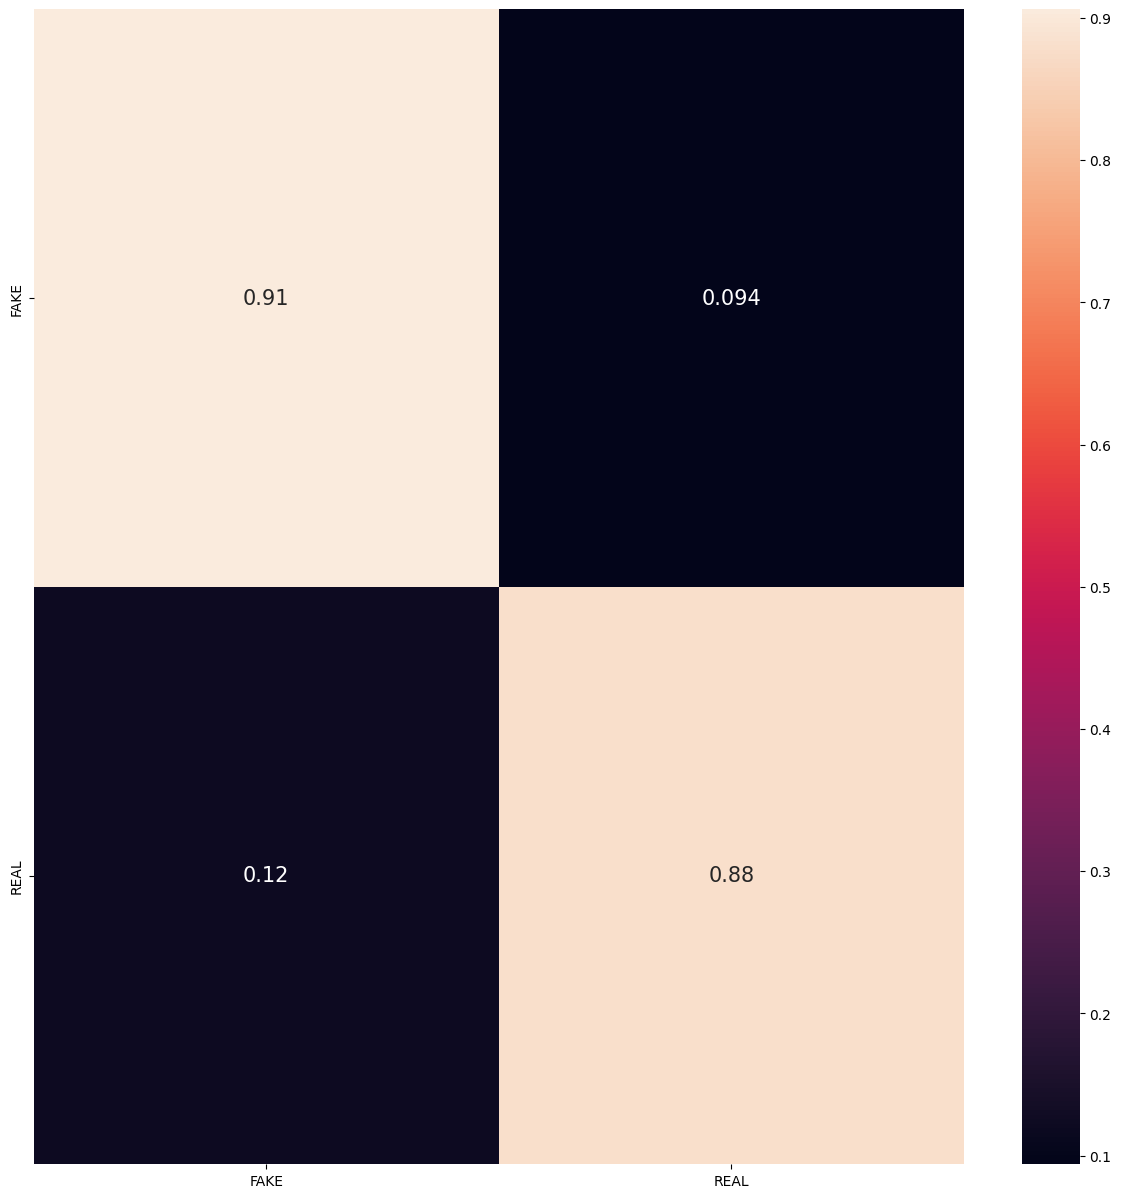

In [132]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['FAKE','REAL'],columns = ['FAKE','REAL'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Again, the model's score is very poor, but keep in mind it hasn't gone through hyperparameter tuning. Let's see how it performs on some test text.

In [133]:
sentiment = ['FAKE','REAL']

In [141]:
sequence = tokenizer.texts_to_sequences(['Trump takes on Cruz, but lightly'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 43ms/step


'REAL'

In [142]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 36ms/step


'FAKE'

In [140]:
sequence = tokenizer.texts_to_sequences(['You Can Smell Hillary’s Fear'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 37ms/step


'FAKE'

In [139]:
sequence = tokenizer.texts_to_sequences(['Kerry to go to Paris in gesture of sympathy'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 37ms/step


'REAL'

# Preparing model for AWS SageMaker

In [138]:
#Saving weights and tokenizer so we can reduce training time on SageMaker

# serialize model to JSON
model_json = best_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
best_model.save_weights("model-weights.h5")
print("Model saved")

# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Tokenizer saved')

Model saved
Tokenizer saved


We've reached the end of this notebook. I just wanted to highlight a few things before let you go.

As you could see, very simple networks can achieve fantastic results. To go beyond, always the best approach is to build a model that underfit the data, then optimize it to overfit and finally start tuning your hyperparameters to achieve the metric that the business needs to reach. The way you tune the model is up to you, there's no magic formula for it, but adding regularization always works, as well as dropout.

If you have any doubt, please feel free to comment :)